## UNet Residual Experiment

Does adding a residual connection to the upsampling path improve performance? This notebook shows a side by side comparison.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.vision.learner import cnn_config
from fastai.vision.models.unet import _get_sfs_idxs

In [3]:
print(torch.cuda.is_available())

True


In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[WindowsPath('C:/Users/GATEWAY/.fastai/data/camvid/codes.txt'),
 WindowsPath('C:/Users/GATEWAY/.fastai/data/camvid/images'),
 WindowsPath('C:/Users/GATEWAY/.fastai/data/camvid/labels'),
 WindowsPath('C:/Users/GATEWAY/.fastai/data/camvid/valid.txt')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

The networks are trained on the Camvid dataset using all classes

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[WindowsPath('C:/Users/GATEWAY/.fastai/data/camvid/images/0001TP_006690.png'),
 WindowsPath('C:/Users/GATEWAY/.fastai/data/camvid/images/0001TP_006720.png'),
 WindowsPath('C:/Users/GATEWAY/.fastai/data/camvid/images/0001TP_006750.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[WindowsPath('C:/Users/GATEWAY/.fastai/data/camvid/labels/0001TP_006690_P.png'),
 WindowsPath('C:/Users/GATEWAY/.fastai/data/camvid/labels/0001TP_006720_P.png'),
 WindowsPath('C:/Users/GATEWAY/.fastai/data/camvid/labels/0001TP_006750_P.png')]

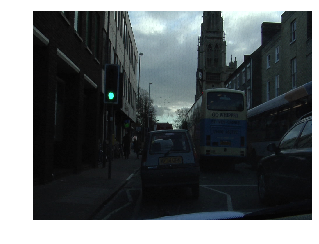

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

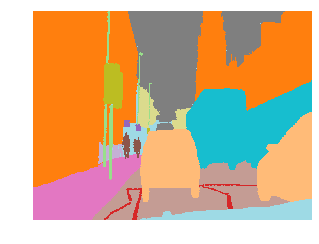

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

We start by training on 180x240 images

In [14]:
src_size/4

array([180., 240.])

In [15]:
size = src_size//4
bs=8

In [16]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [17]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

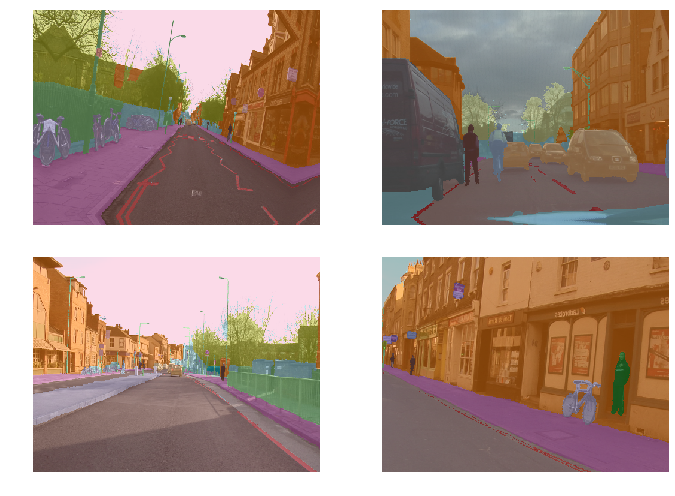

In [17]:
data.show_batch(2, figsize=(10,7))

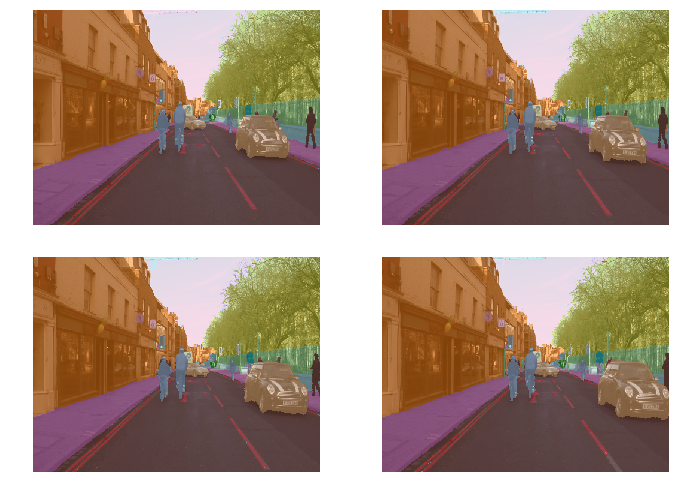

In [18]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Baseline Model

The intent of this notebook was to use the default fastai UNet both with and without a residual connection. However making this work required tweaking the model design in ways that inflated the model's size. Specifically, we need to turn

`self.conv2(self.conv1(cat_x))`

Into

`cat_x + self.conv2(self.conv1(cat_x))`

This means the output of the two convolutions must have the same number of channels as the input. The default behavior was for the channels to be halved at most layers. Changing this to accommodate a residual connection significantly increases the memory usage of the upsampling path. 

This is enough of a change that we need to test the modified model without residual connections to establish a fair baseline.

Training procedure:
We train the decoder of the model on 180x240 images for 10 epochs. Then we train the entire model for 12 epochs.
We increase the image size to 360x480, and train the decoder for another 10 epochs. We then unfreeze and train for another 10 epochs.
We do not train on full sized images due to memory constraints.

Both models (with and without residual connections) will be trained with the same procedure using the same learning rate and momentum schedule. Then we will compare the final loss, accuracy and qualitative performance of the two models.

In [18]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [19]:
metrics=acc_camvid
# metrics=accuracy

In [20]:
wd=1e-2

In [21]:
def unet_learner1(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=NormType, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, **kwargs:Any)->None:
    "Build Unet learner from `data` and `arch`."
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    model = to_device(DynamicUnet1(body, n_classes=data.c, blur=blur, blur_final=blur_final,
          self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
          bottle=bottle), data.device)
    learn = Learner(data, model, **kwargs)
    learn.split(ifnone(split_on,meta['split']))
    if pretrained: learn.freeze()
    apply_init(model[2], nn.init.kaiming_normal_)
    return learn

In [22]:
class UnetBlock1(nn.Module):
    "A quasi-UNet block, using `PixelShuffle_ICNR upsampling`."
    def __init__(self, up_in_c:int, x_in_c:int, hook:Hook, final_div:bool=True, blur:bool=False, leaky:float=None,
                 self_attention:bool=False, **kwargs):
        super().__init__()
        self.hook = hook
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
        self.bn = batchnorm_2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = ni if final_div else ni//2
        self.conv1 = conv_layer(ni, nf, leaky=leaky, **kwargs)
        # Original: self.conv2 = conv_layer(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
        # the output number of filters, nf, is changed to ni to accommodate a residual connection
        self.conv2 = conv_layer(nf, ni, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        s = self.hook.stored
        up_out = self.shuf(up_in)
        ssh = s.shape[-2:]
        if ssh != up_out.shape[-2:]:
            up_out = F.interpolate(up_out, s.shape[-2:], mode='nearest')
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        # No residual connection yet
        return self.conv2(self.conv1(cat_x))


class DynamicUnet1(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder:nn.Module, n_classes:int, blur:bool=False, blur_final=True, self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        x = dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv_layer(ni, ni*2, **kwargs),
                                    conv_layer(ni*2, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = UnetBlock1(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=blur, self_attention=sa,
                                   **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
        layers += [conv_layer(ni, n_classes, ks=1, use_activ=False, **kwargs)]
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

In [23]:
learn = unet_learner1(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


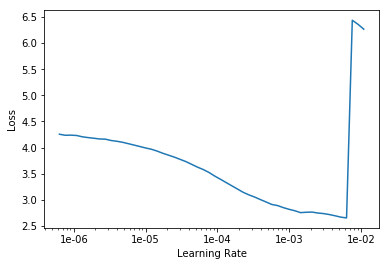

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=3e-3

In [26]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,1.203338,0.846369,0.796911
2,0.861050,0.635557,0.837491
3,0.721420,0.551363,0.850371
4,0.677696,0.557708,0.846700
5,0.648339,0.504019,0.872926
6,0.626823,0.520366,0.861362
7,0.607938,0.456623,0.881630
8,0.589200,0.612499,0.831851
9,0.565190,0.486495,0.866761
10,0.500350,0.396358,0.884548


In [27]:
learn.save('stage-1')

In [28]:
learn.load('stage-1');

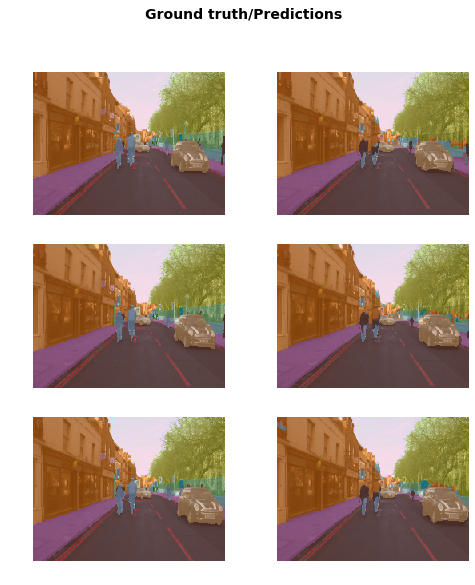

In [29]:
learn.show_results(rows=3, figsize=(8,9))

In [30]:
learn.unfreeze()

In [31]:
lrs = slice(lr/400,lr/4)

In [32]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.430149,0.373947,0.892266
2,0.414064,0.359946,0.896943
3,0.406864,0.346928,0.901721
4,0.396683,0.332672,0.908145
5,0.393201,0.349317,0.900039
6,0.383529,0.350311,0.899469
7,0.377710,0.365740,0.892499
8,0.367807,0.330533,0.901318
9,0.353826,0.347036,0.902065
10,0.343206,0.332489,0.906652


In [33]:
learn.save('stage-2');

In [23]:
size = src_size//2
bs=4

In [24]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [27]:
learn = unet_learner1(data, models.resnet34, metrics=metrics, wd=wd)

In [28]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


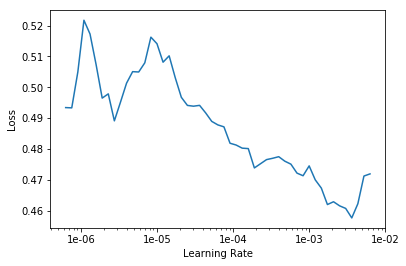

In [29]:
lr_find(learn)
learn.recorder.plot()

In [30]:
lr=1e-3

In [31]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.405690,0.354836,0.898326
2,0.377388,0.336817,0.900133
3,0.357905,0.350027,0.904172
4,0.355169,0.304650,0.913312
5,0.352276,0.379592,0.892633
6,0.341242,0.333378,0.901103
7,0.355836,0.351854,0.901695
8,0.341659,0.341803,0.903644
9,0.303477,0.322240,0.909271
10,0.252851,0.294165,0.918071


In [32]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [33]:
learn.unfreeze()

In [34]:
lrs = slice(1e-6,lr/10)

In [35]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.242534,0.293892,0.918333
2,0.239759,0.286368,0.920173
3,0.239669,0.286377,0.920356
4,0.241457,0.286532,0.919915
5,0.229484,0.292628,0.919027
6,0.228743,0.280785,0.921888
7,0.225198,0.284397,0.921622
8,0.219350,0.285610,0.922412
9,0.217316,0.290233,0.921359
10,0.217815,0.290226,0.921004


In [36]:
learn.save('stage-2-big')

In [24]:
learn.load('stage-2-big');

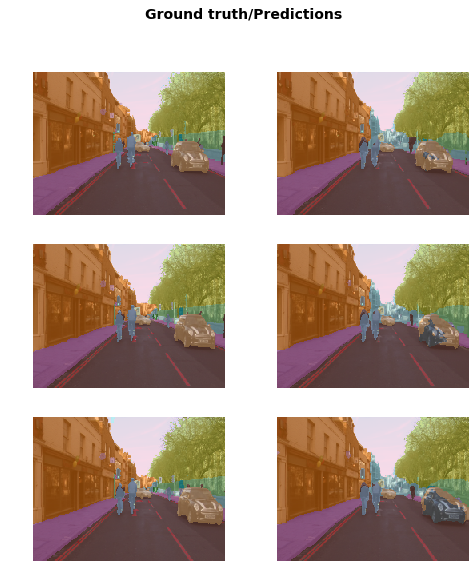

In [25]:
learn.show_results(rows=3, figsize=(8,9))

The baseline model achieved a final training loss/validation loss/accuracy of 0.217/0.290/0.921.

Qualitatively the model struggles with correctly outlining the cyclists and the car.

# Residual Model

Now we add a residual connection to the model

In [21]:
def unet_learner2(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=NormType, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, **kwargs:Any)->None:
    "Build Unet learner from `data` and `arch`."
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    model = to_device(DynamicUnet2(body, n_classes=data.c, blur=blur, blur_final=blur_final,
          self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
          bottle=bottle), data.device)
    learn = Learner(data, model, **kwargs)
    learn.split(ifnone(split_on,meta['split']))
    if pretrained: learn.freeze()
    apply_init(model[2], nn.init.kaiming_normal_)
    return learn

In [22]:
class UnetBlock2(nn.Module):
    "A quasi-UNet block, using `PixelShuffle_ICNR upsampling`."
    def __init__(self, up_in_c:int, x_in_c:int, hook:Hook, final_div:bool=True, blur:bool=False, leaky:float=None,
                 self_attention:bool=False, **kwargs):
        super().__init__()
        self.hook = hook
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
        self.bn = batchnorm_2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = ni if final_div else ni//2
        self.conv1 = conv_layer(ni, nf, leaky=leaky, **kwargs)
        # Original: self.conv2 = conv_layer(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
        # the output number of filters, nf, is changed to ni to accommodate a residual connection
        self.conv2 = conv_layer(nf, ni, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        s = self.hook.stored
        up_out = self.shuf(up_in)
        ssh = s.shape[-2:]
        if ssh != up_out.shape[-2:]:
            up_out = F.interpolate(up_out, s.shape[-2:], mode='nearest')
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        # Residual Connection added
        return cat_x + self.conv2(self.conv1(cat_x))


class DynamicUnet2(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder:nn.Module, n_classes:int, blur:bool=False, blur_final=True, self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        x = dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv_layer(ni, ni*2, **kwargs),
                                    conv_layer(ni*2, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = UnetBlock2(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=blur, self_attention=sa,
                                   **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
        layers += [conv_layer(ni, n_classes, ks=1, use_activ=False, **kwargs)]
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

In [23]:
learn = unet_learner2(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


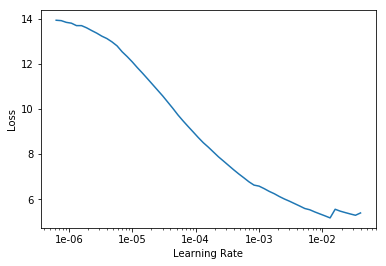

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=3e-3

In [26]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,1.412083,0.928664,0.774531
2,0.942638,0.704689,0.809013
3,0.766218,0.604474,0.839352
4,0.673183,0.624205,0.837150
5,0.631350,0.554811,0.846899
6,0.597737,0.427877,0.883080
7,0.570547,0.514693,0.862943
8,0.574380,0.698611,0.814660
9,0.543319,0.470094,0.881977
10,0.474032,0.383509,0.887924


In [27]:
learn.save('stage-3')

In [28]:
learn.load('stage-3');

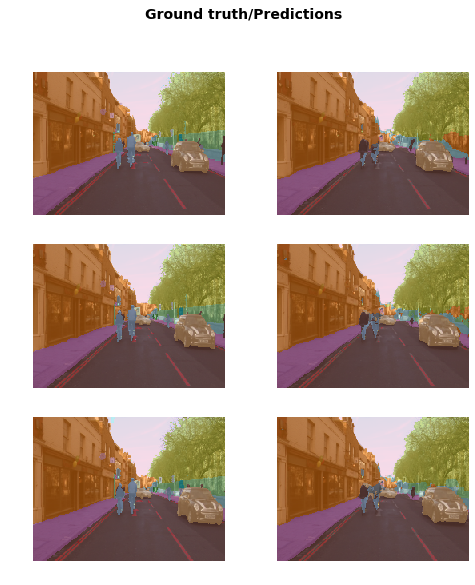

In [29]:
learn.show_results(rows=3, figsize=(8,9))

In [30]:
learn.unfreeze()

In [31]:
lrs = slice(lr/400,lr/4)

In [32]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.403040,0.367487,0.894534
2,0.395038,0.358345,0.897444
3,0.384809,0.362678,0.894092
4,0.374150,0.357684,0.896563
5,0.363684,0.346082,0.900089
6,0.357661,0.350962,0.900168
7,0.349648,0.352708,0.896857
8,0.342093,0.335037,0.904971
9,0.335603,0.368373,0.892138
10,0.327626,0.348079,0.900828


In [33]:
learn.save('stage-4');

In [24]:
size = src_size//2
bs=4

In [25]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [26]:
learn = unet_learner2(data, models.resnet34, metrics=metrics, wd=wd)

In [27]:
learn.load('stage-4');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


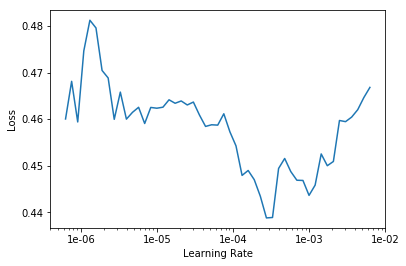

In [28]:
lr_find(learn)
learn.recorder.plot()

In [29]:
lr=1e-3

In [30]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.374254,0.350750,0.897816
2,0.345190,0.339483,0.900970
3,0.334245,0.315092,0.905965
4,0.326840,0.310185,0.908826
5,0.328541,0.340279,0.902543
6,0.321939,0.299714,0.914485
7,0.312245,0.290346,0.914017
8,0.307747,0.341766,0.895428
9,0.274809,0.283594,0.916188
10,0.228123,0.266474,0.921912


In [31]:
learn.save('stage-3-big')

In [ ]:
learn.load('stage-3-big');

In [32]:
learn.unfreeze()

In [33]:
lrs = slice(1e-6,lr/10)

In [34]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.224093,0.263232,0.923406
2,0.218978,0.263089,0.923943
3,0.220283,0.267890,0.923309
4,0.214510,0.267809,0.923420
5,0.208788,0.269655,0.925289
6,0.205270,0.272351,0.923562
7,0.193641,0.266735,0.925111
8,0.199451,0.268179,0.925542
9,0.196491,0.267317,0.926625
10,0.195352,0.264220,0.927012


In [35]:
learn.save('stage-4-big')

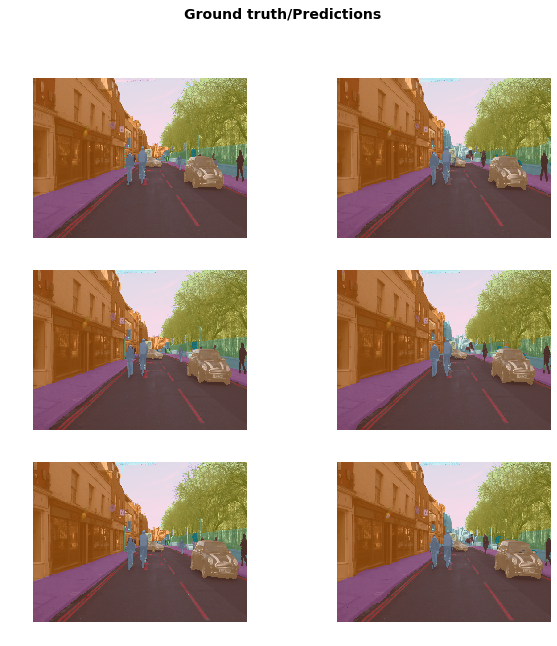

In [36]:
learn.show_results(rows=3, figsize=(10,10))

The residual model achieved a final training loss/validation loss/accuracy of 0.195/0.264/0.927.

Qualitatively this model performs much better on the pedestrials and the parked car. 

# Comparison

The residual model trained to a lower loss and higher accuracy over the same training schedule. It also produces better looking masks with more complete segmentations. I would say the residual model performs better.

However the residual model comes with a memory cost. With the default fastai UNet I was able to run full sized Camvid images on a GPU with 11GB of memory. This model maxed out at half size images with a batch size of 4. Perhaps a leaner version of this model is worth investigating.